# Détectez des faux billets

# Sommaire


* [1. Importation des librairies et du fichier](#1)
    * [1.1 Importation des librairies](#1_1)
    * [1.2 Importation du fichier](#1_2)
* [2. Prétraitement des données](#2)
    * [2.1 Visualisation du dataframe](#2_1)
    * [2.2 Traitement des valeurs manquantes](#2_2)
        * [2.2.1 Régression linéaire multiple et inspection des résultats avec l'ensemble des variables](#2_2_1)
        * [2.2.2 Retrait des variables non significatives](#2_2_2)
        * [2.2.3 Evaluation du modèle](#2_2_3)
    * [2.3 Estimation des valeurs manquantes](#2_3)
* [3. Régression logistique](#3)
    * [3.1 Séparation Train Set/ Test Set](#3_1)
    * [3.2 Modélisation et lecture des résultats](#3_2)
    * [3.3 Sélection de variables](#3_3)
    * [3.4 Evaluation sur l'échantillon test](#3_4)
    * [3.5 Courbe d'apprentissage](#3_5)
* [4. Classification par K-Means](#4)
    * [4.1 Séparation Train Set/ Test Set](#4_1)
    * [4.2 Standardisation des données](#4_2)
    * [4.3 Méthode du coude](#4_3)
    * [4.4 Calcul des 2 clusters](#4_4)
    * [4.5 Affichage des données du Test Set avec les prédictions du KMeans](#4_5)
        * [4.5.1 Création du Dataframe avec les données du Test Set et identification des clusters](#4_5_1)
        * [4.5.2 Visualisation des erreurs de prédictions](#4_5_2)
    * [4.6 Visualisation des clusters sur le repère des composantes principales 1 et 2](#4_6)
    * [4.7 Analyse des caractéristiques des clusters](#4_7)
        * [4.7.1 Visualisation en boxplots](#4_7_1)
        * [4.7.2 Visualisation en radarplots](#4_7_2)
    * [4.8 Evaluation du modèle](#4_8)
* [5. Conclusion](#5)
* [6. Enregistrement des données utiles à l'application finale](#6)

## 1. Importation des librairies et du fichier <a class="anchor" id="1"></a>

### 1.1 Importation des librairies <a class="anchor" id="1_1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pour la régression linéaire multiple
import statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro

# Pour la régression logistique
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import learning_curve

# Pour le KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Pour le stockage du modèle
import pickle

# Ignorer tous les avertissements
import warnings
warnings.filterwarnings("ignore")

### 1.2 Importation du fichier <a class="anchor" id="1_2"></a>

In [2]:
# Création du Dataframe 'billets'
billets = pd.read_csv('billets.csv', delimiter=";")

## 2. Prétraitement des données <a class="anchor" id="2"></a>

### 2.1 Visualisation du dataframe <a class="anchor" id="2_1"></a>

In [3]:
# Prévisualisation du dataframe
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [4]:
# Vérifions les dimensions
print('Dimension du jeu de données :', billets.shape)

Dimension du jeu de données : (1500, 7)


In [5]:
# Check des doublons
if billets.duplicated().sum() > 0:
    print('Le nombre de doublons présents dans le Dataframe est de : ', billets.duplicated().sum())
else:
    print('Pas de doublons présents dans le Dataframe.')

Pas de doublons présents dans le Dataframe.


In [6]:
# Vérification du contenu du dataframe et du type de données
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [7]:
# Convertir les données booléennes en 0 et 1
billets.is_genuine = billets.is_genuine.astype(int)

In [8]:
# Affichons les statistiques descriptives
billets.describe()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,0.666667,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.471562,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,0.000000,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,0.000000,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,1.000000,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,1.000000,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,1.000000,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


Il manque des données pour la marge entre le bord inférieur du billet et l'image 'margin_low'.

### 2.2 Traitement des valeurs manquantes <a class="anchor" id="2_2"></a>

Pour estimer les valeurs manquantes de notre dataframe, nous allons réaliser une régression linéaire multiple.

In [9]:
# Utilisons les données sans NaN comme train set pour entrainer notre modèle de regression linéaire multiple
train_set = billets.dropna()

#### 2.2.1 Régression linéaire multiple et inspection des résultats avec l'ensemble des variables <a class="anchor" id="2_2_1"></a>

In [10]:
# Instanciation de l'objet régression et estimation des paramètres avec .fit()
# Les moindres carrés ordinaires sont utilisés avec la variable cible 'margin_low' 
# ainsi qu'avec les variables explicatives qui sont les autres variables.
reg_multi = smf.ols('margin_low~is_genuine+diagonal+height_left+height_right+margin_up+length', data=train_set).fit()

# Affichage des résultats
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     390.7
Date:                Wed, 08 Nov 2023   Prob (F-statistic):          4.75e-299
Time:                        12:12:15   Log-Likelihood:                -774.14
No. Observations:                1463   AIC:                             1562.
Df Residuals:                    1456   BIC:                             1599.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.8668      8.316      0.345   

Le coefficient de détermination R² est de 0.617, et le R² ajusté permet de corriger le R² en tenant compte du nombre de variables explicatives que nous avons considérées. Il n'est pas très différent du R², car il est de 0.615. 

Le modèle explique donc environ 61% de la variance totale des données. 

On constate ici que certains paramètres ne sont pas significativement différents de 0, car leur p-valeur est supérieure à 5 %, le niveau de test que nous souhaitons.

#### 2.2.2 Retrait des variables non significatives <a class="anchor" id="2_2_2"></a>

On va donc maintenant retirer les variables non significatives (p-valeur > 5%).

In [11]:
reg_multi = smf.ols('margin_low~is_genuine+margin_up', data=train_set).fit()

# Affichage des résultats
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                Wed, 08 Nov 2023   Prob (F-statistic):          1.24e-304
Time:                        12:12:15   Log-Likelihood:                -774.73
No. Observations:                1463   AIC:                             1555.
Df Residuals:                    1460   BIC:                             1571.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9263      0.198     30.003      0.0

#### 2.2.3 Evaluation du modèle <a class="anchor" id="2_2_3"></a>

#### La droite de Henry

On va tracer le graphique quantile-quantile plot pour évaluer la compatibilité des résidus avec une distribution gaussienne.

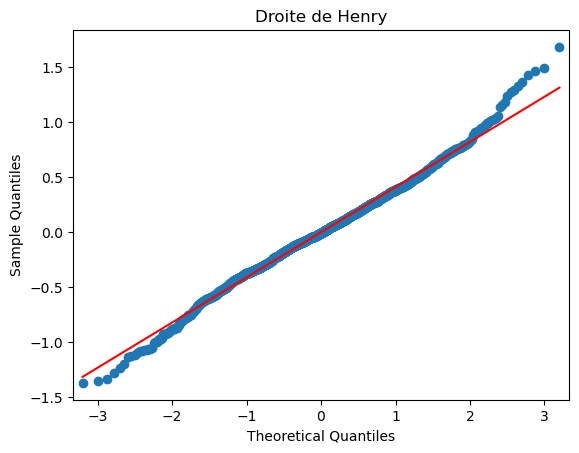

In [12]:
# Traçons qq plot des quantiles centrés-réduits en fonction des quantiles sous l'hypothèse gaussienne
sm.qqplot(reg_multi.resid, line='s')
plt.title('Droite de Henry')
plt.show()

Nous ne sommes pas loin d'une droite, donc on semble compatible avec une loi Normale. 

#### Graphique des résidus avec l'endogène

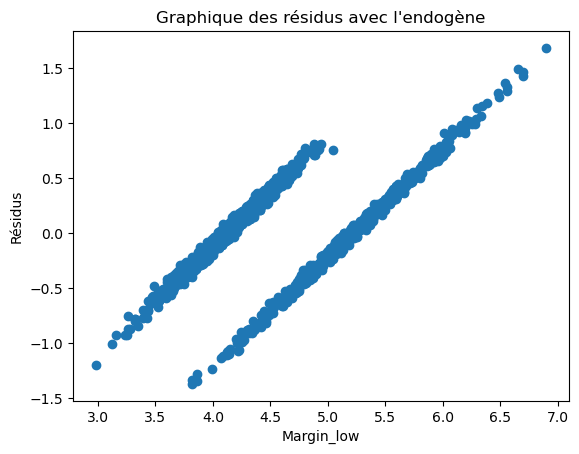

In [13]:
# On va tracer le graphique des résidus avec l'endogène
plt.scatter(train_set.margin_low, reg_multi.resid)
plt.xlabel('Margin_low')
plt.ylabel('Résidus')
plt.title("Graphique des résidus avec l'endogène")
plt.show()

La dispersion des résidus est homogène, il a bien une constance de la variance des résidus. 
Cela valide l'hypothèse de linéarité de notre modèle.

Nous allons ici réaliser les tests à un niveau $\alpha=5$% :

In [14]:
alpha = 0.05

Récupérons $n$, le nombre d'individus de l'échantillon, et $p$, le nombre de variables.

In [15]:
n = train_set.shape[0]
p = 3

#### Calculer les leviers

On peut calculer les leviers comme ceci, en sachant que le seuil des leviers est de $2∗\frac{p}{n}$.

Nous allons mener des analyses sur les valeurs atypiques et/ou influentes en travaillant sur un dataframe appelé  analyses.

In [16]:
analyses = pd.DataFrame({'obs':np.arange(1, n+1)})

In [17]:
analyses['levier'] = reg_multi.get_influence().hat_matrix_diag

seuil_levier = 2*p/n
print('Le seuil des leviers est de :', seuil_levier)

Le seuil des leviers est de : 0.004101161995898838


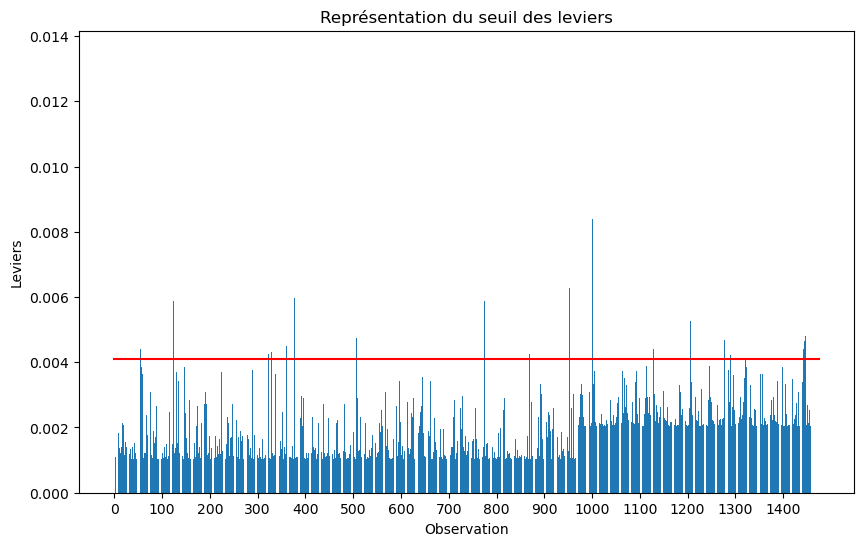

In [18]:
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['levier'])
plt.xticks(np.arange(0, 1500, step=100))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.title('Représentation du seuil des leviers')
plt.plot([0, 1475], [seuil_levier, seuil_levier], color='r')
plt.show()

Pour sélectionner les points pour lesquels le levier est supérieur au seuil, on exécute la ligne suivante :

In [19]:
analyses.loc[analyses['levier'] > seuil_levier, :]

,obs,levier
4,5,0.004748
48,49,0.007353
52,53,0.010647
54,55,0.004408
123,124,0.005865
...,...,...
1441,1442,0.005428
1442,1443,0.004406
1444,1445,0.004648
1446,1447,0.004796


Nous avons donc 67 individus concernés.

#### Calculez les résidus studentisés

Si l'on souhaite maintenant calculer les résidus studentisés, nous écrivons ceci, sachant que le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de liberté :

In [20]:
analyses['rstudent'] = reg_multi.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

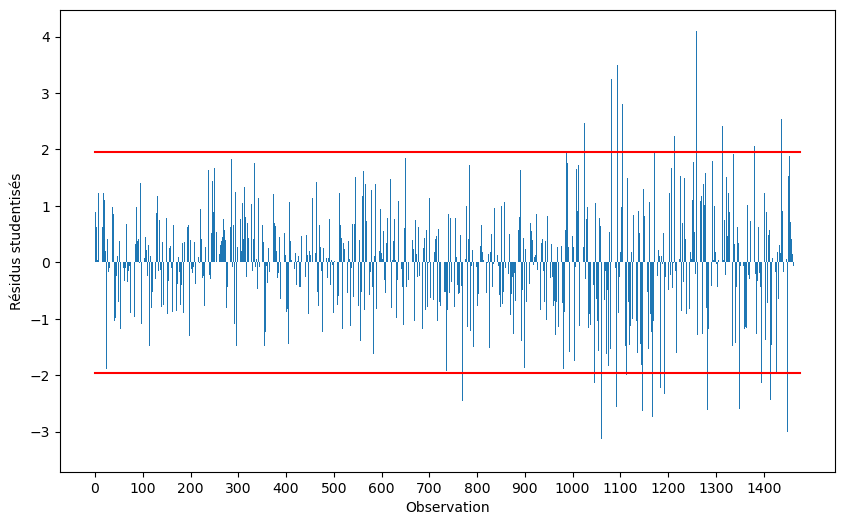

In [21]:
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['rstudent'])
plt.xticks(np.arange(0, 1500, step=100))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, 1475], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 1475], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

#### Déterminez la distance de Cook

Pour trouver la distance de Cook, nous exécutons ceci :

In [22]:
influence = reg_multi.get_influence().summary_frame()

Le seuil de la distance de Cook est de n-p.

In [23]:
analyses['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p)

On peut détecter les observations influentes comme ceci :

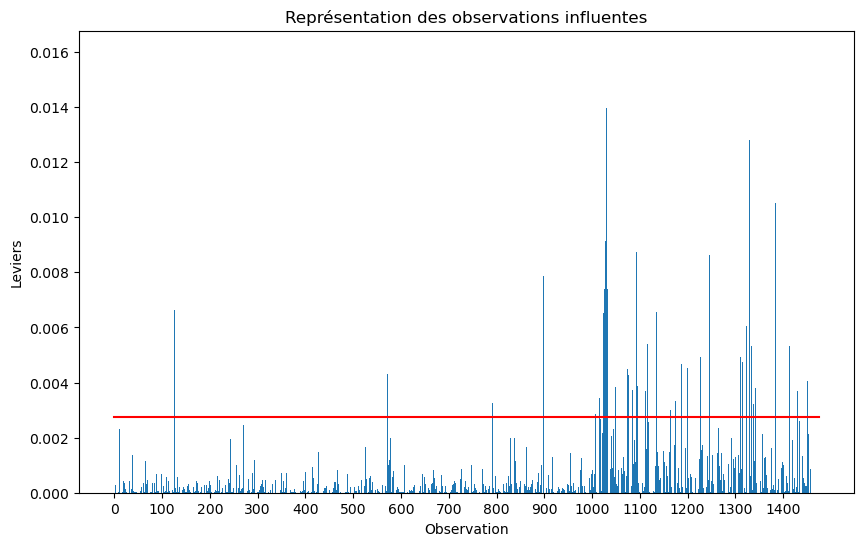

In [24]:
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['dcooks'])
plt.xticks(np.arange(0, 1500, step=100))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.title('Représentation des observations influentes')
plt.plot([0, 1475], [seuil_dcook, seuil_dcook], color='r')
plt.show()

On ne retire des points qu'après avoir vérifié qu'ils sont effectivement atypiques, voire aberrants, au vu du modèle estimé.

 Vérifions les points à la fois atypiques et influents.


In [25]:
atypiques_influents = analyses.loc[(analyses['dcooks'] > seuil_dcook) & (analyses['levier'] > seuil_levier)]
atypiques_influents

,obs,levier,rstudent,dcooks
52,53,0.010647,-1.174185,0.004945
1060,1061,0.004948,-0.818204,0.003919
1348,1349,0.004692,-2.589306,0.008852
1378,1379,0.005313,1.703834,0.003382
1426,1427,0.004228,-1.940064,0.005707
1441,1442,0.005428,2.317452,0.010969


In [26]:
# On va créer un dataframe temporaire en supprimant les valeurs atypiques et influentes
billets_temp = train_set.drop(index=atypiques_influents.index)

Vérifions si le modèle de régression linéaire est amélioré : 

In [27]:
# Instanciation de l'objet régression et estimation des paramètres avec .fit()
# Les moindre carrées ordinaires avec la variable cible 'margin_low' et les variables explicatives qui sont les autres variables
reg_multi = smf.ols('margin_low~is_genuine+margin_up', data=billets_temp).fit()

# Affichage des résultats
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     1178.
Date:                Wed, 08 Nov 2023   Prob (F-statistic):          6.68e-305
Time:                        12:12:19   Log-Likelihood:                -757.67
No. Observations:                1457   AIC:                             1521.
Df Residuals:                    1454   BIC:                             1537.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.8454      0.197     29.644      0.0

Le modèle est un peu amélioré, on estimera donc avec les données de billets_temp.

#### Vérifier la colinéarité des variables

Une autre chose à vérifier est l'éventuelle colinéarité approchée des variables :

In [28]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.6086605032860677, 1.608660503286068]

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

#### Testez l’homoscédasticité

On peut également tester l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus :

In [29]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 1.467693982476723e-34


La p-valeur ici est inférieure à $5$%, on rejette l'hypothèse $H0$ selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).

#### Testez la normalité des résidus

Si l'on veut tester la normalité des résidus, on peut faire un test de Shapiro-Wilk.

In [30]:
shapiro(reg_multi.resid)

ShapiroResult(statistic=0.9938036203384399, pvalue=8.994408744911198e-06)

Ici, l'hypothèse de normalité est remise en cause (p-value = 0.00000705 < 0.05).

Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que **les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes**, même si le résidu n'est pas considéré comme étant gaussien.

### 2.3 Estimation des valeurs manquantes <a class="anchor" id="2_2_3"></a>

In [31]:
# Réalisons la prédiction
X = billets.drop(columns = ['margin_low'],axis=1) 
prédiction = reg_multi.predict(X)
print(prédiction)

0       4.147277
1       4.128409
2       4.137843
3       4.124636
4       4.035956
          ...   
1495    5.262382
1496    5.209552
1497    5.211439
1498    5.192570
1499    5.209552
Length: 1500, dtype: float64


In [32]:
# Estimation avec prédiction des valeurs manquantes
billets['margin_low']= billets['margin_low'].fillna(prédiction)
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   int32  
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: float64(6), int32(1)
memory usage: 76.3 KB


### 2.3 Analyse exploratoire <a class="anchor" id="2_3"></a>

In [33]:
# Affichons les statistiques descriptives
billets.describe()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,0.666667,171.958440,104.029533,103.920307,4.482841,3.151473,112.67850
std,0.471562,0.305195,0.299462,0.325627,0.659810,0.231813,0.87273
min,0.000000,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,0.000000,171.750000,103.820000,103.710000,4.027500,2.990000,112.03000
50%,1.000000,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,1.000000,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,1.000000,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


Nous pouvons remarquer que la moyenne de margin_low à très peu évolué suite à la prédiction des valeurs manquantes.

Les prédictions semblent donc cohérentes, nous pouvons continuer l'analyse.

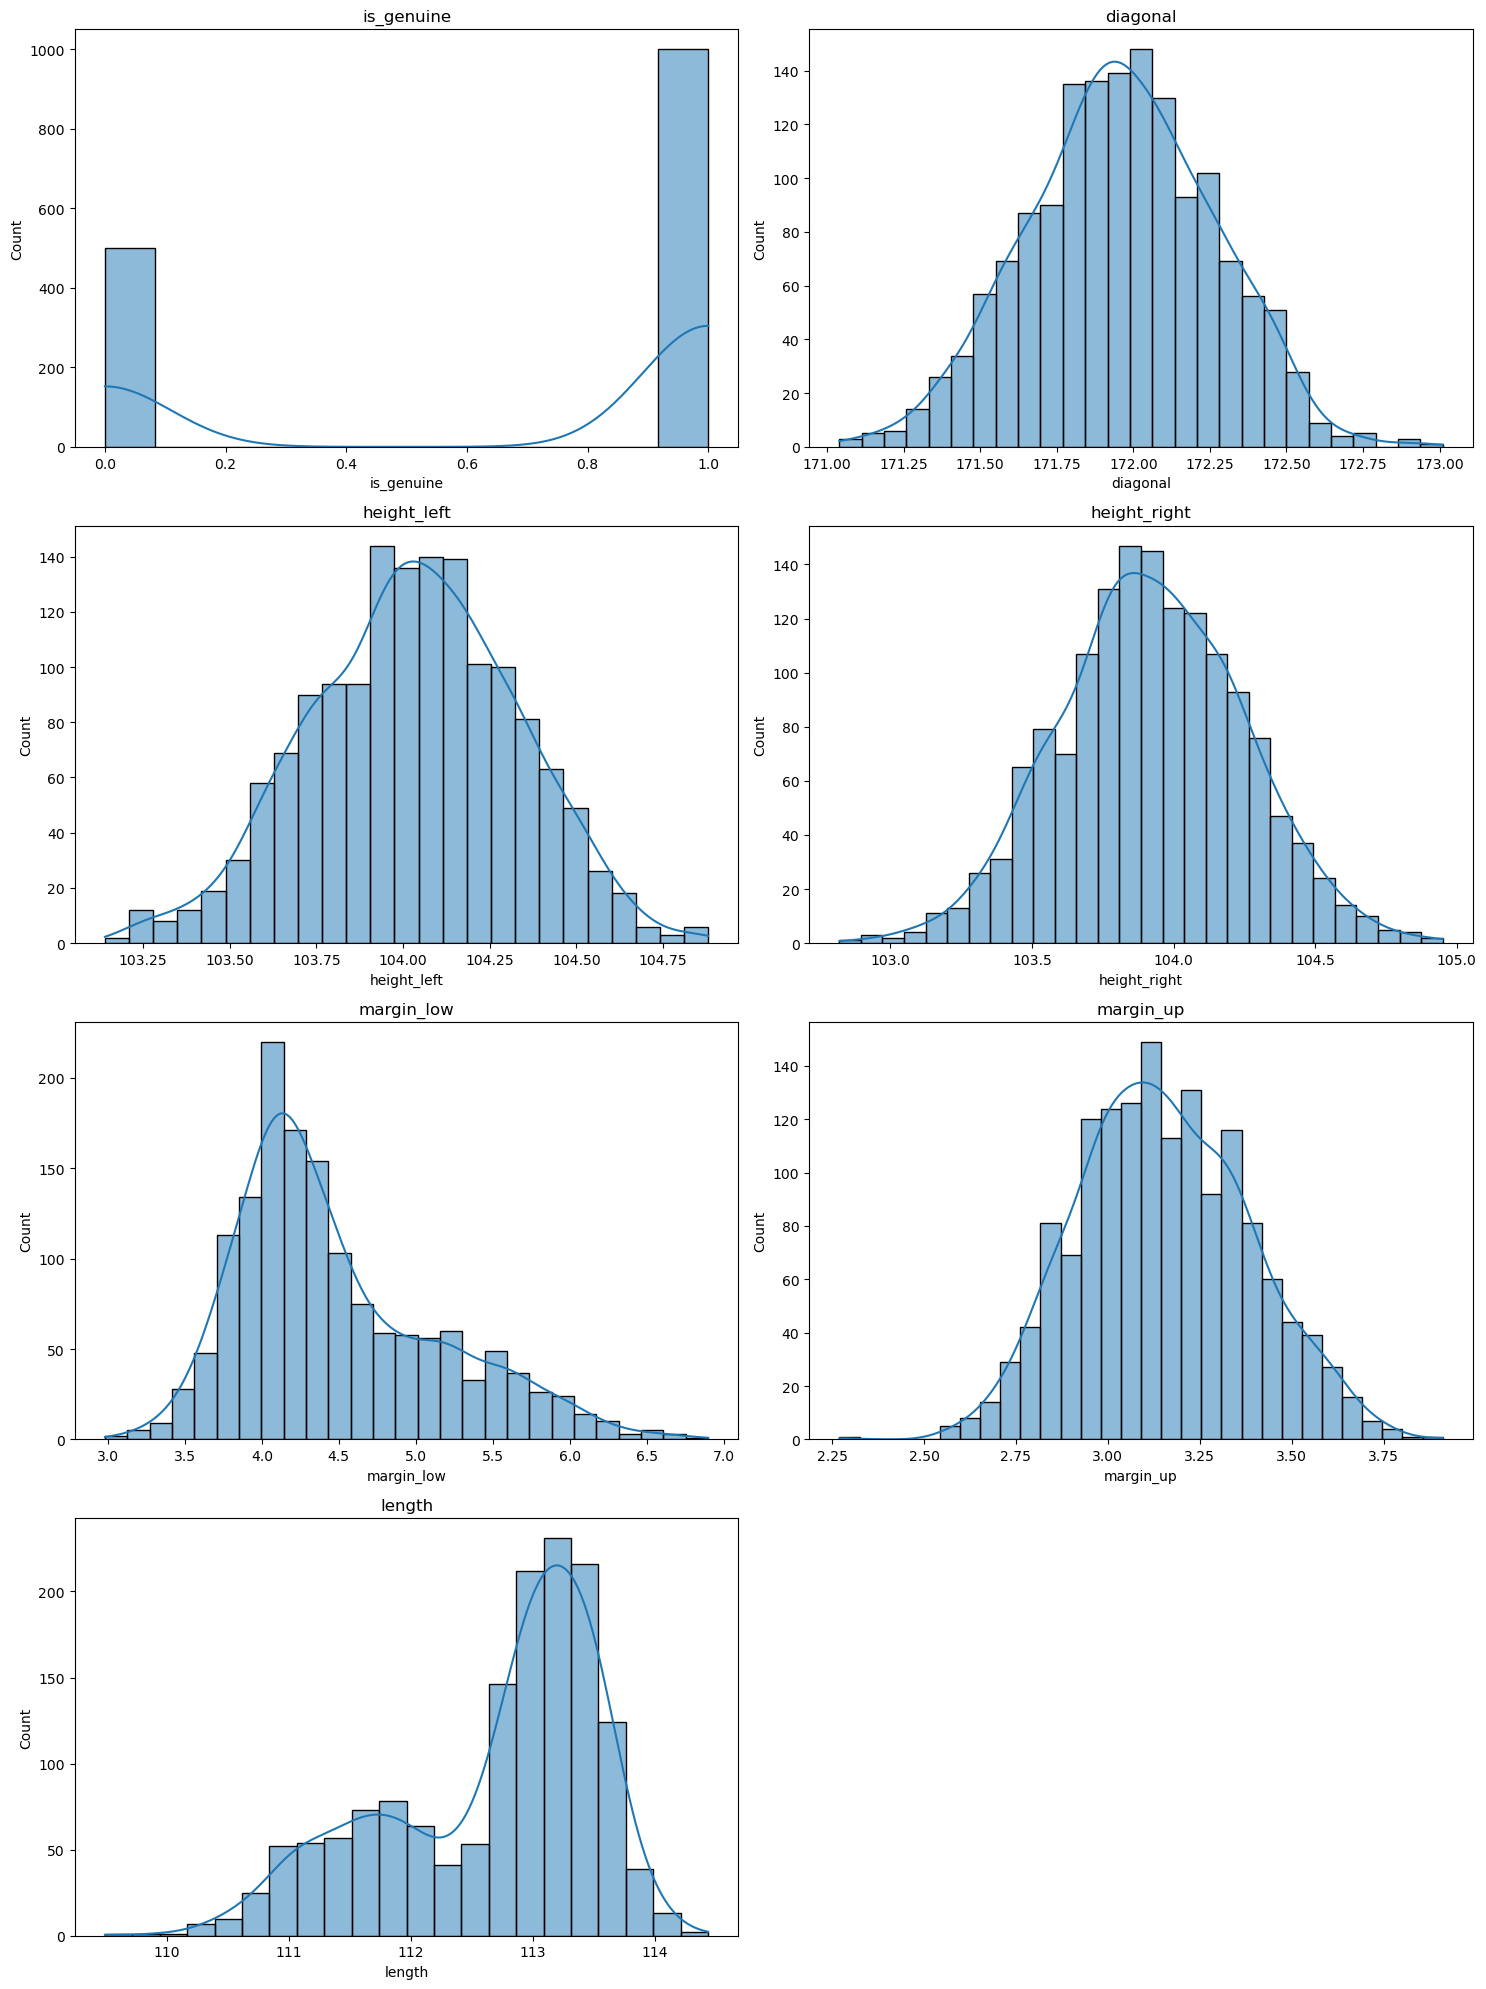

In [34]:
# Affichons la distribution de chaque variable
plt.figure(figsize=(15,20))

for i, colonne in enumerate(billets.columns):
    plt.subplot(4, 2, i+1)
    sns.histplot(billets[colonne], kde=True)
    plt.title(colonne)

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher le graphique
plt.show()

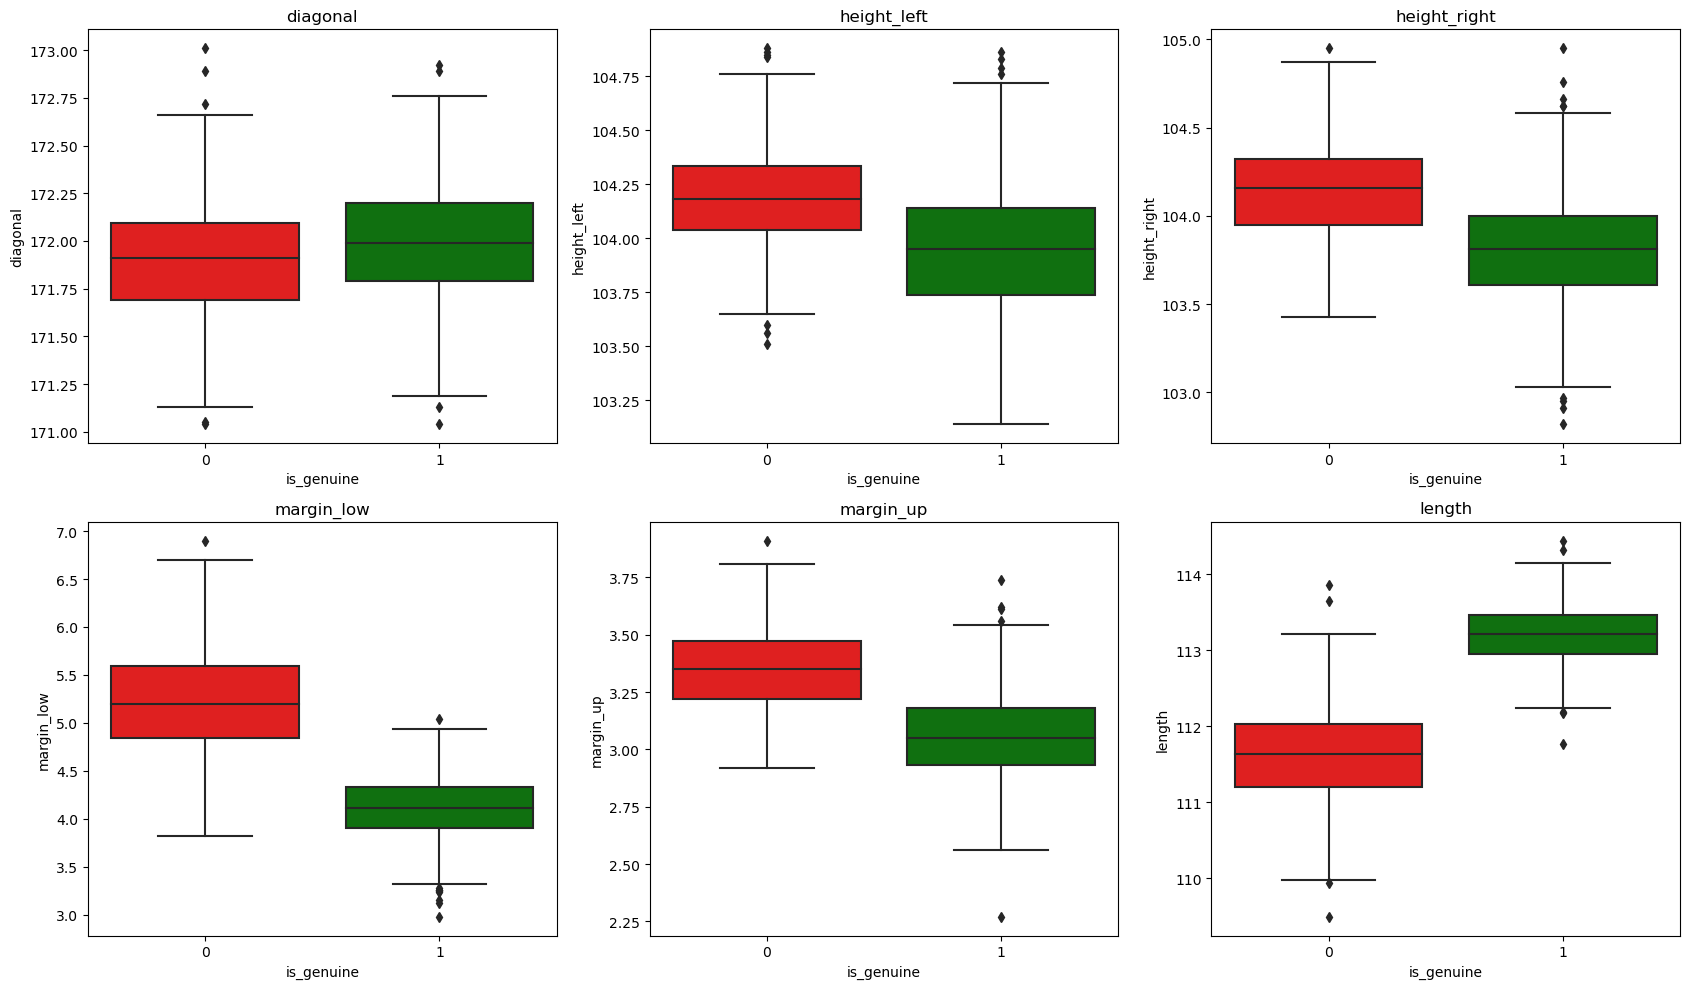

In [35]:
# Création d'une copy du Dataframe 'billets' sans la colonne 'is_genuine'
df_billets_copy = billets.copy().drop(columns='is_genuine', axis=1)

# Affichons la répartition des valeurs suivant les vrais et faux billets avec des boxplots
plt.figure(figsize=(17,10))

for i, colonne in enumerate(df_billets_copy.columns):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='is_genuine', y=colonne, data=billets, palette=['red', 'green'])
    plt.title(colonne)
    
# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher le graphique
plt.show()

<Figure size 640x480 with 0 Axes>

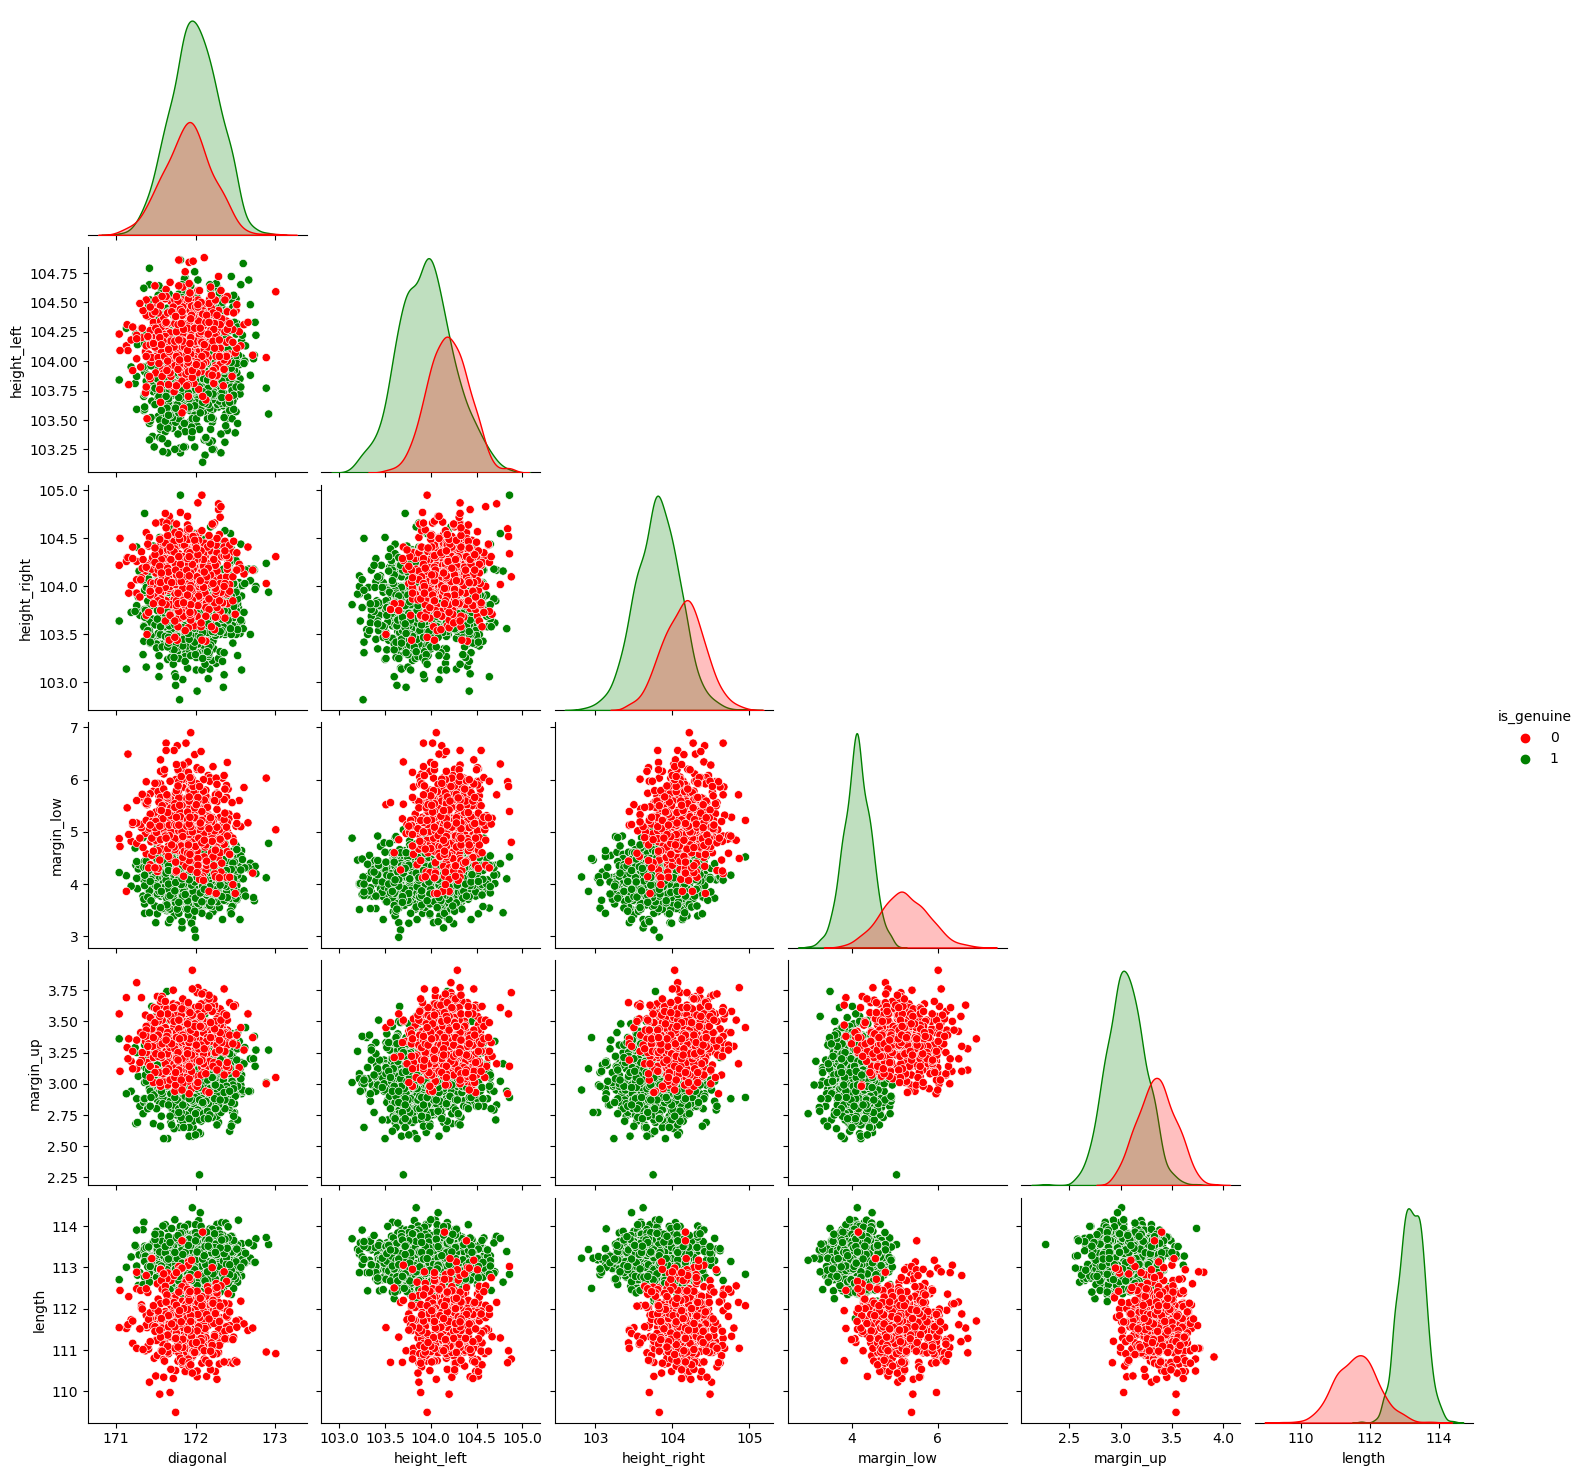

In [36]:
# Affichons un graphique croisant toutes les variables en séparant les vrais billets des faux
plt.figure()
sns.pairplot(billets, hue='is_genuine', palette=['red', 'green'], corner=True)
plt.show()

In [37]:
# Regardons le nombre de vrais billets par rapport au nombre de faux billets présents dans le DataFrame
df_nb_billets = billets.groupby('is_genuine').count()['diagonal'].reset_index().rename(columns={'diagonal':'Nombre de billets'})
df_nb_billets['is_genuine'] = df_nb_billets['is_genuine'].replace({0: 'faux billets', 1: 'vrais billets'})
df_nb_billets

,is_genuine,Nombre de billets
0,faux billets,500
1,vrais billets,1000


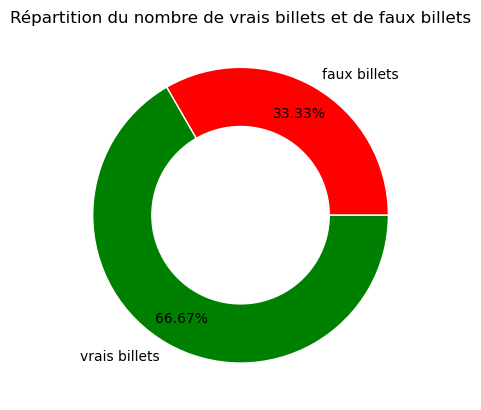

In [38]:
# Répartition du nombre de vrais billets et de faux billets
colors = ['red', 'green']

plt.figure()
plt.pie(df_nb_billets['Nombre de billets'], labels=df_nb_billets['is_genuine'], autopct='%.2f%%', pctdistance=0.8, wedgeprops={'width': 0.4, 'edgecolor':'white'}, colors=colors)
plt.title("Répartition du nombre de vrais billets et de faux billets")
plt.show()

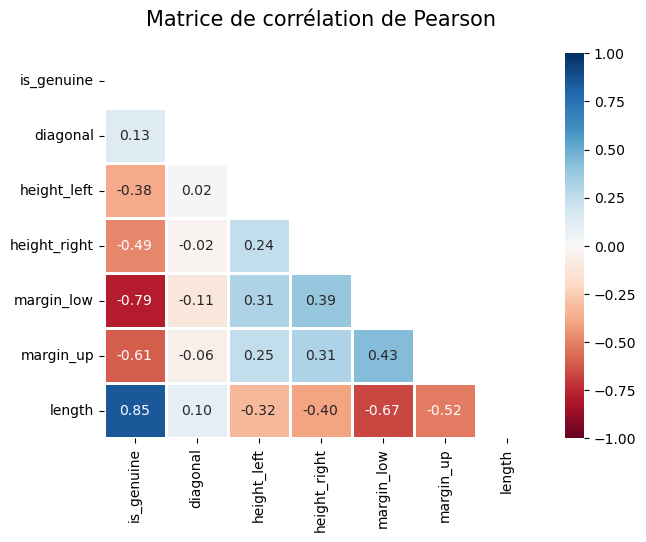

In [39]:
# Matrice des corrélations de Pearson
mask = np.triu(np.ones_like(billets.corr(), dtype=bool))
plt.figure(figsize=(7,5))
sns.heatmap(billets.corr(), mask=mask, center=0, cmap='RdBu', linewidths=1, annot=True, fmt='.2f', vmin=-1, vmax=1)
plt.title('Matrice de corrélation de Pearson', fontsize=15, y=1.05)
plt.show()

Grâce à la matrice des corrélations de Pearson, nous pouvons déjà voir que les variables les plus corrélées à 'is_genuine' (vrais ou faux billets) sont : 

    - 'height_right'
    - 'margin_low'
    - 'margin_up'
    - 'length'

## 3. Régression logistique <a class="anchor" id="3"></a>

### 3.1 Séparation Train Set/ Test Set <a class="anchor" id="3_1"></a>

In [40]:
# Il faut d'abord séparer les données
X = billets.drop('is_genuine', axis=1)
y = billets['is_genuine'] 

# On peut ensuite séparer les jeux de données en Train set et Test set
Xtrain_LogReg, Xtest_LogReg, ytrain_LogReg, ytest_LogReg = train_test_split(X, y, train_size=0.8, random_state=1)

### 3.2 Modélisation et lecture des résultats <a class="anchor" id="3_2"></a>

In [41]:
# Instanciation et apprentissage
model_LogReg = LogisticRegression(random_state=1993)
model_LogReg.fit(Xtrain_LogReg, ytrain_LogReg)

LogisticRegression(random_state=1993)

In [42]:
# Affichage des coefficients
print(model_LogReg.coef_)

[[-0.17224547 -1.45905467 -1.99502065 -3.58966875 -3.13771721  3.6943689 ]]


In [43]:
# Utilisons un meilleur affichage pour une meilleure lecture des coefficients
coef = pd.DataFrame(model_LogReg.coef_[0], index=X.columns, columns=['coef'])
coef.sort_values(by='coef', ascending=False, key=lambda v:abs(v))

,coef
length,3.694369
margin_low,-3.589669
margin_up,-3.137717
height_right,-1.995021
height_left,-1.459055
diagonal,-0.172245


Les variables sont exprimées dans la même unité (en mm), on va donc pouvoir utiliser les coefficients pour faire une sélection de variables.

### 3.3 Sélection de variables <a class="anchor" id="3_3"></a>

In [44]:
# On va donc identifier le nombre optimal de features en utilisant la cross-validation (RFECV)
select = RFECV(estimator=model_LogReg, cv=15, scoring='accuracy')
select.fit(Xtrain_LogReg, ytrain_LogReg)

RFECV(cv=15, estimator=LogisticRegression(random_state=1993),
      scoring='accuracy')

In [45]:
# Regardons le score à chaque étape des validations croisées (score moyen par nombre de variables)
scores = select.cv_results_['mean_test_score']
scores = pd.DataFrame(scores, columns=['Scores'])
print(scores)

     Scores
0  0.932500
1  0.975833
2  0.986667
3  0.990000
4  0.990000
5  0.989167


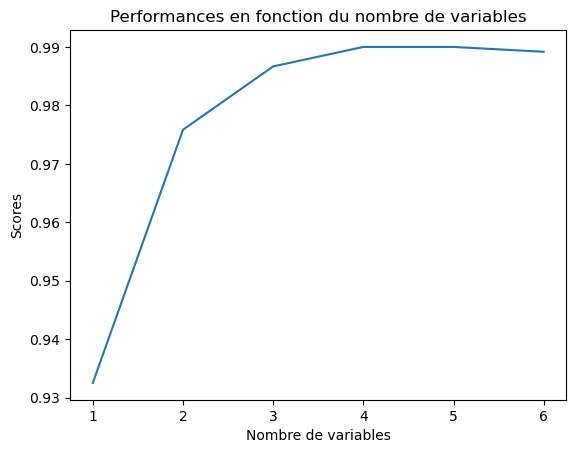

In [46]:
# Graphique avec les perfomances en fonction du nombre de variables
plt.figure()
plt.plot(np.arange(1,7,1),scores)
plt.xlabel('Nombre de variables')
plt.ylabel('Scores')
plt.title('Performances en fonction du nombre de variables')
plt.show()

In [47]:
# Nombre de variables sélectionnées
sélection = X.columns[select.support_]
print('Le nombre de variables sélectionnées est de :', select.n_features_)
print()
print('Les variables sélectionnées sont :', sélection)

Le nombre de variables sélectionnées est de : 4

Les variables sélectionnées sont : Index(['height_right', 'margin_low', 'margin_up', 'length'], dtype='object')


### 3.4 Evaluation sur l'échantillon test <a class="anchor" id="3_4"></a>

In [48]:
# Prédiction sur l'échantillon test avec les variables sélectionnées
y_pred_LogReg = select.estimator_.predict(Xtest_LogReg[Xtest_LogReg.columns[select.support_]])

# Affichage du nombre de faux billets et de vrais billets (prédits) dans l'échantillon test
print(np.unique(y_pred_LogReg, return_counts=True))

(array([0, 1]), array([ 97, 203], dtype=int64))


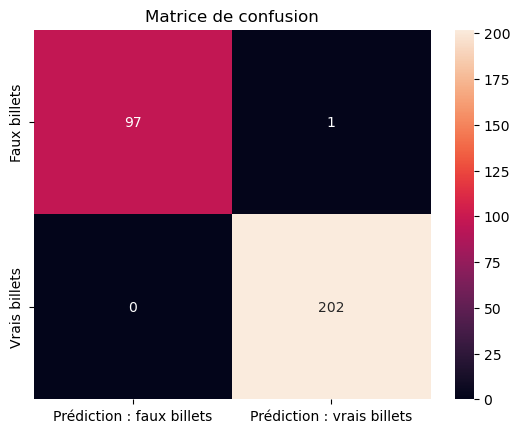

In [49]:
# Matrice de confusion
matrice_confusion = metrics.confusion_matrix(ytest_LogReg, y_pred_LogReg)

sns.heatmap(matrice_confusion,annot=True, fmt="d",
            xticklabels=['Prédiction : faux billets', 'Prédiction : vrais billets'],
            yticklabels=['Faux billets', 'Vrais billets'])
plt.title('Matrice de confusion')
plt.show()

Sur les 300 billets du Test set, le modèle a prédit : 

    - 97 faux billets (pour réellement 98 faux billets),
    - et, 203 vrais billets (pour réellement 202 vrais billets).

In [50]:
# Performances globales
print(metrics.classification_report(ytest_LogReg, y_pred_LogReg))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        98
           1       1.00      1.00      1.00       202

    accuracy                           1.00       300
   macro avg       1.00      0.99      1.00       300
weighted avg       1.00      1.00      1.00       300



In [51]:
# Calculons le coefficient de détermination R2
print('Le coefficent de détermination R2 est de :', model_LogReg.score(Xtest_LogReg, ytest_LogReg))

Le coefficent de détermination R2 est de : 0.9933333333333333


In [52]:
# Affichage des résultats sur le Dataframe
probabilités = select.estimator_.predict_proba(Xtest_LogReg[Xtest_LogReg.columns[select.support_]])

# Créez des DataFrames à partir des données Xtest et ytest
df_ytest_LogReg = pd.DataFrame(ytest_LogReg, columns=['is_genuine'])
df_Xtest_LogReg = pd.DataFrame(Xtest_LogReg, columns=X.columns)

# Concaténez les DataFrames
df_RegLog = pd.concat([df_ytest_LogReg, df_Xtest_LogReg], axis=1)
df_RegLog['is_genuine'] = df_RegLog['is_genuine'].astype(bool)
df_RegLog['Prédictions'] = y_pred_LogReg
df_RegLog['Prédictions'] = df_RegLog['Prédictions'].astype(bool)
df_RegLog['Indice de confiance'] = np.max(probabilités, axis=1)
df_RegLog

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,Prédictions,Indice de confiance
91,True,172.08,104.01,104.50,4.30,2.97,113.05,True,0.960721
75,True,172.26,103.85,103.70,4.16,3.20,112.35,True,0.830882
1264,False,171.92,104.33,104.06,4.45,3.41,111.46,False,0.986799
330,True,171.99,104.12,104.18,4.41,2.75,113.18,True,0.989563
1349,False,171.53,104.03,104.05,5.77,3.22,111.93,False,0.998805
...,...,...,...,...,...,...,...,...,...
1094,False,172.13,104.40,103.43,4.44,3.65,111.17,False,0.993907
1204,False,171.96,104.01,104.54,5.21,3.31,111.35,False,0.999694
1130,False,171.56,104.29,104.19,5.23,3.63,112.94,False,0.902901
12,True,171.89,103.89,103.40,4.11,2.96,113.24,True,0.998637


Affichons maintenant la mauvaise prédiction et regardons l'indice de confiance.

In [53]:
df_RegLog_badpred = df_RegLog.loc[df_RegLog['is_genuine'] != df_RegLog['Prédictions']]
df_RegLog_badpred

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,Prédictions,Indice de confiance
1407,False,172.02,103.99,104.28,4.22,2.98,112.42,True,0.79147


Étant donné que l'indice de confiance pour cette prédiction erronée de notre modèle est quand même proche de 80%, il serait légitime de se demander si l'ajout de plus de données d'entraînement pourrait contribuer à son amélioration.

### 3.5 Courbe d'apprentissage <a class="anchor" id="3_5"></a>

Nous allons utiliser la courbe d'apprentissage pour évaluer la performance du modèle en fonction de la quantité de données d'entraînement utilisées.

Nombre de données par lot :
[  11  134  257  380  504  627  750  873  996 1120]


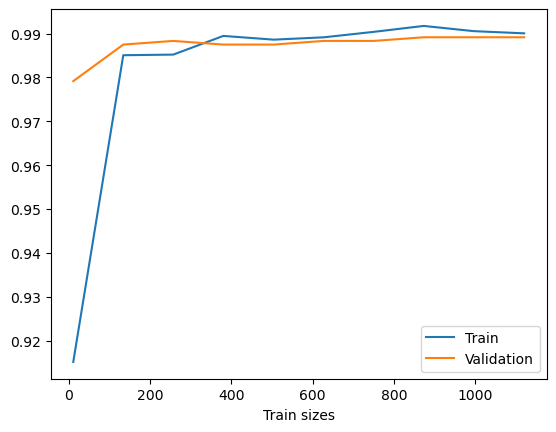

In [54]:
# Traçons la courbe d'apprentissage et le score de validation croisé associé
N, train_score, val_score = learning_curve(select.estimator_, Xtrain_LogReg, ytrain_LogReg,
                            train_sizes= np.linspace(0.01, 1.0, 10), cv=15)

print('Nombre de données par lot :')
print(N)
plt.plot(N, train_score.mean(axis=1), label='Train')
plt.plot(N, val_score.mean(axis=1), label='Validation')
plt.xlabel('Train sizes')
plt.legend()
plt.show()

Nous pouvons observer que les meilleurs scores sont obtenus à partir de 873 données, et le score a tendance à stagner voire baisser avec plus de données. 

Étant donné que notre modèle a été entraîné avec 1200 billets, nous pouvons raisonnablement penser que l'ajout de plus de données n'améliorera pas significativement notre modèle.

## 4. Classification par K-Means <a class="anchor" id="4"></a>

### 4.1 Séparation Train Set/ Test Set <a class="anchor" id="4_1"></a>

In [55]:
# X la matrice des données
X = billets.drop(['is_genuine'], axis=1)

# y les étiquettes de données
y = billets.is_genuine

# On peut ensuite séparer les jeux de données en Train set et Test set
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, random_state=28072023)

### 4.2 Standardisation des données <a class="anchor" id="4_2"></a>

In [56]:
# Features les variables
features = X.columns

# Il faut scaler les données dans un premier temps. On instancie : 
scaler = StandardScaler()

# On entraine le scaler sur nos données : 
scaler.fit(Xtrain)

StandardScaler()

In [57]:
# On transforme nos données
X_scaled_train = scaler.transform(Xtrain)
X_scaled_test = scaler.transform(Xtest)

In [58]:
# On vérifie que la moyenne est à 0 et que l'écart type est à 1 
idx = ['mean', 'std']

pd.DataFrame(X_scaled_train).describe().round(2).loc[idx, :]

,0,1,2,3,4,5
mean,0.0,0.0,0.0,0.0,0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0


### 4.3 Méthode du coude <a class="anchor" id="4_3"></a>

In [59]:
# Il faut créer une liste où on va stocker toutes les distances pour les différentes valeurs de k (nous utiliserons nos données centrées réduites)
somme_distances = []

for i in range(1,7):
    kmeans = KMeans(n_clusters = i, random_state=0)
    kmeans.fit_predict(X_scaled_train)
    somme_distances.append(kmeans.inertia_)

somme_distances

[7199.999999999999,
 4652.970060900819,
 4102.066135394665,
 3766.277151813283,
 3505.704714982882,
 3288.4968013530242]

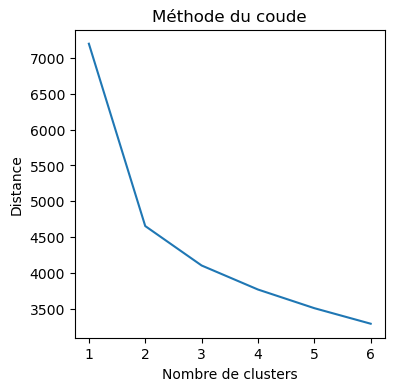

In [60]:
# La méthode du coude nous permettra de pouvoir visualiser le nombre optimal de clusters
plt.figure(figsize=(4,4))
plt.plot(range (1,7), somme_distances)
plt.title('Méthode du coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('Distance')
plt.show()

Le nombre optimal de cluster est de 2. On va donc avoir les clusters : 

    - Vrais billets
    - Faux billets

### 4.4 Calcul des 2 clusters <a class="anchor" id="4_4"></a>

In [61]:
# Initions notre modèle pour 2 clusters
model_Kmeans = KMeans(n_clusters=2, random_state=1993)

# Entrainons notre modèle 
clusters_kmeans = model_Kmeans.fit(X_scaled_train)

# Création d'une variable pour nos centroïdes
centroids = model_Kmeans.cluster_centers_

### 4.5 Affichage des données du Test Set avec les prédictions du KMeans <a class="anchor" id="4_5"></a>

#### 4.5.1 Création du Dataframe avec les données du Test Set et identification des clusters <a class="anchor" id="4_5_1"></a>

In [62]:
# Créez des DataFrames à partir des données Xtest et ytest
df_ytest = pd.DataFrame(ytest, columns=['is_genuine'])
df_Xtest = pd.DataFrame(Xtest, columns=X.columns)

# Concaténez les DataFrames
df_test_KMeans = pd.concat([df_ytest, df_Xtest], axis=1)

# Rajoutons la colonne avec les clusters KMeans pour le train set non centré/ non réduit
df_test_KMeans['Clusters_KMeans'] = clusters_kmeans.predict(X_scaled_test)

# Identifions les vrais des faux billets dans la prédiction du KMeans
# Pour cela, il faut calculer la moyenne des clusters KMeans correspondant au 0 et 1 de 'is_genuine'
cluster_proportions = df_test_KMeans.groupby('Clusters_KMeans')['is_genuine'].mean()
cluster_proportions

Clusters_KMeans
0    0.990148
1    0.030928
Name: is_genuine, dtype: float64

In [63]:
# Puis, on va identifier quel cluster correspond aux vrais billets (max proportion)
cluster_vrai = cluster_proportions.idxmax()

# Et quel cluster correspond aux faux billets (min proportion)
cluster_faux = cluster_proportions.idxmin()

print(f"Cluster des vrais billets : {cluster_vrai}")
print(f"Cluster des faux billets : {cluster_faux}")

Cluster des vrais billets : 0
Cluster des faux billets : 1


In [64]:
# On peut maintenant changer le type de données pour 'is_genuine'
df_test_KMeans['is_genuine'] = df_test_KMeans['is_genuine'].astype(bool)

# Définir un dictionnaire de remplacement pour les clusters
clusters = {cluster_vrai: 1, cluster_faux: 0}

# Remplacer les valeurs du cluster selon le dictionnaire de remplacement
df_test_KMeans['Clusters_KMeans'] = df_test_KMeans['Clusters_KMeans'].map(clusters)

# Changer le type de donnée pour booléen
df_test_KMeans['Clusters_KMeans'] = df_test_KMeans['Clusters_KMeans'].astype(bool)

df_test_KMeans.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,Clusters_KMeans
744,True,172.10,103.95,103.72,4.49,3.07,113.15,True
820,True,171.88,104.44,103.50,4.53,3.06,113.52,True
1108,False,171.78,104.24,103.94,4.64,3.11,111.31,False
925,True,171.82,103.61,103.84,3.99,2.73,113.40,True
1082,False,171.75,103.96,103.83,5.39,3.54,109.49,False


#### 4.5.2 Visualisation des erreurs de prédictions <a class="anchor" id="4_5_2"></a>

In [65]:
df_Kmeans_badpred = df_test_KMeans.loc[df_test_KMeans['is_genuine'] != df_test_KMeans['Clusters_KMeans']]
df_Kmeans_badpred

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,Clusters_KMeans
743,True,172.30,104.58,104.17,4.360000,3.33,112.98,False
1482,False,172.30,104.04,103.85,4.120000,3.27,111.69,True
1362,False,171.56,103.80,103.87,5.660000,2.98,112.95,True
728,True,171.94,104.11,104.16,4.080000,3.35,111.76,False
946,True,171.63,103.87,104.66,4.075579,3.27,112.68,False


### 4.6 Visualisation des clusters sur le repère des composantes principales 1 et 2 <a class="anchor" id="4_6"></a>

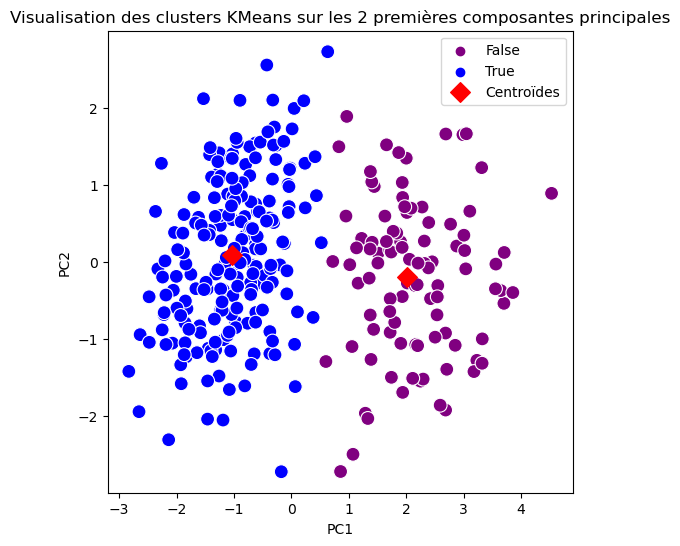

In [66]:
# Réduction à 2 dimensions pour la visualisation
n_components = 2
pca = PCA(n_components=n_components)
X_2d = pca.fit_transform(X_scaled_test)
centroides_acp = pca.transform(centroids)

# Création d'un DataFrame pour les données réduites à 2D
df_2d = pd.DataFrame(data=X_2d, columns=['PC1', 'PC2'])
df_2d['Clusters'] = model_Kmeans.predict(X_scaled_test)

# Remplacement des valeurs '0' et '1' (voir identification des clusters)
df_2d['Clusters'] = df_2d['Clusters'].map(clusters)
df_2d['Clusters'] = df_2d['Clusters'].astype(bool)

# Affichage des données réduites avec couleur selon le cluster
plt.figure(figsize=(6, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Clusters', data=df_2d, palette=['purple', 'blue'], s=100)
plt.scatter(centroides_acp[:, 0], centroides_acp[:, 1], label='Centroïdes', marker='D', c='r', s=100)
plt.legend()
plt.title('Visualisation des clusters KMeans sur les 2 premières composantes principales')
plt.show()

<Axes: >

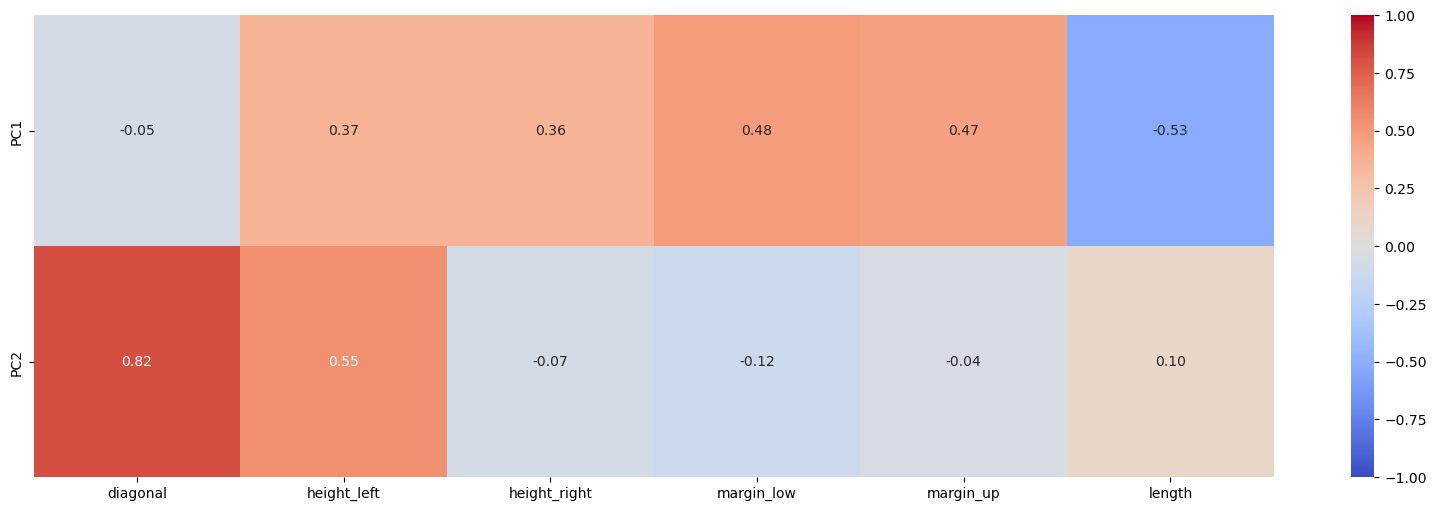

In [67]:
# On va maintenant s'intéresser à nos composantes. On va les obtenir grâce à l'attribut components_
x_list = range(1, n_components+1)
pcs=pca.components_

pcs = pd.DataFrame(pcs)
pcs.columns = features
pcs.index = [f"PC{i}" for i in x_list]
pcs.round(2)

# Regardons la contribution des axes à nos variables avec une heatmap : 
fig, ax = plt.subplots(figsize=(20,6))
sns.heatmap(pcs, vmin=-1, vmax=1, annot=True, cmap='coolwarm', fmt='0.2f')

Nous pouvons voir que la composante principale 2 ne contribue pas à la différenciation des 2 clusters, donc les variables 'diagonal' et 'height_left' ne sont pas significatives dans le modèle. 

Par contre, la composante principale 1 contribue à la différenciation des 2 clusters. Il donc 4 variables qui vont contribuer à la différenciation des vrais et faux billets, à savoir : 'height_right', 'margin_low', 'margin_up' et 'length'.

### 4.7 Analyse des caractéristiques des clusters <a class="anchor" id="4_7"></a>

#### 4.7.1 Visualisation en boxplots <a class="anchor" id="4_7_1"></a>

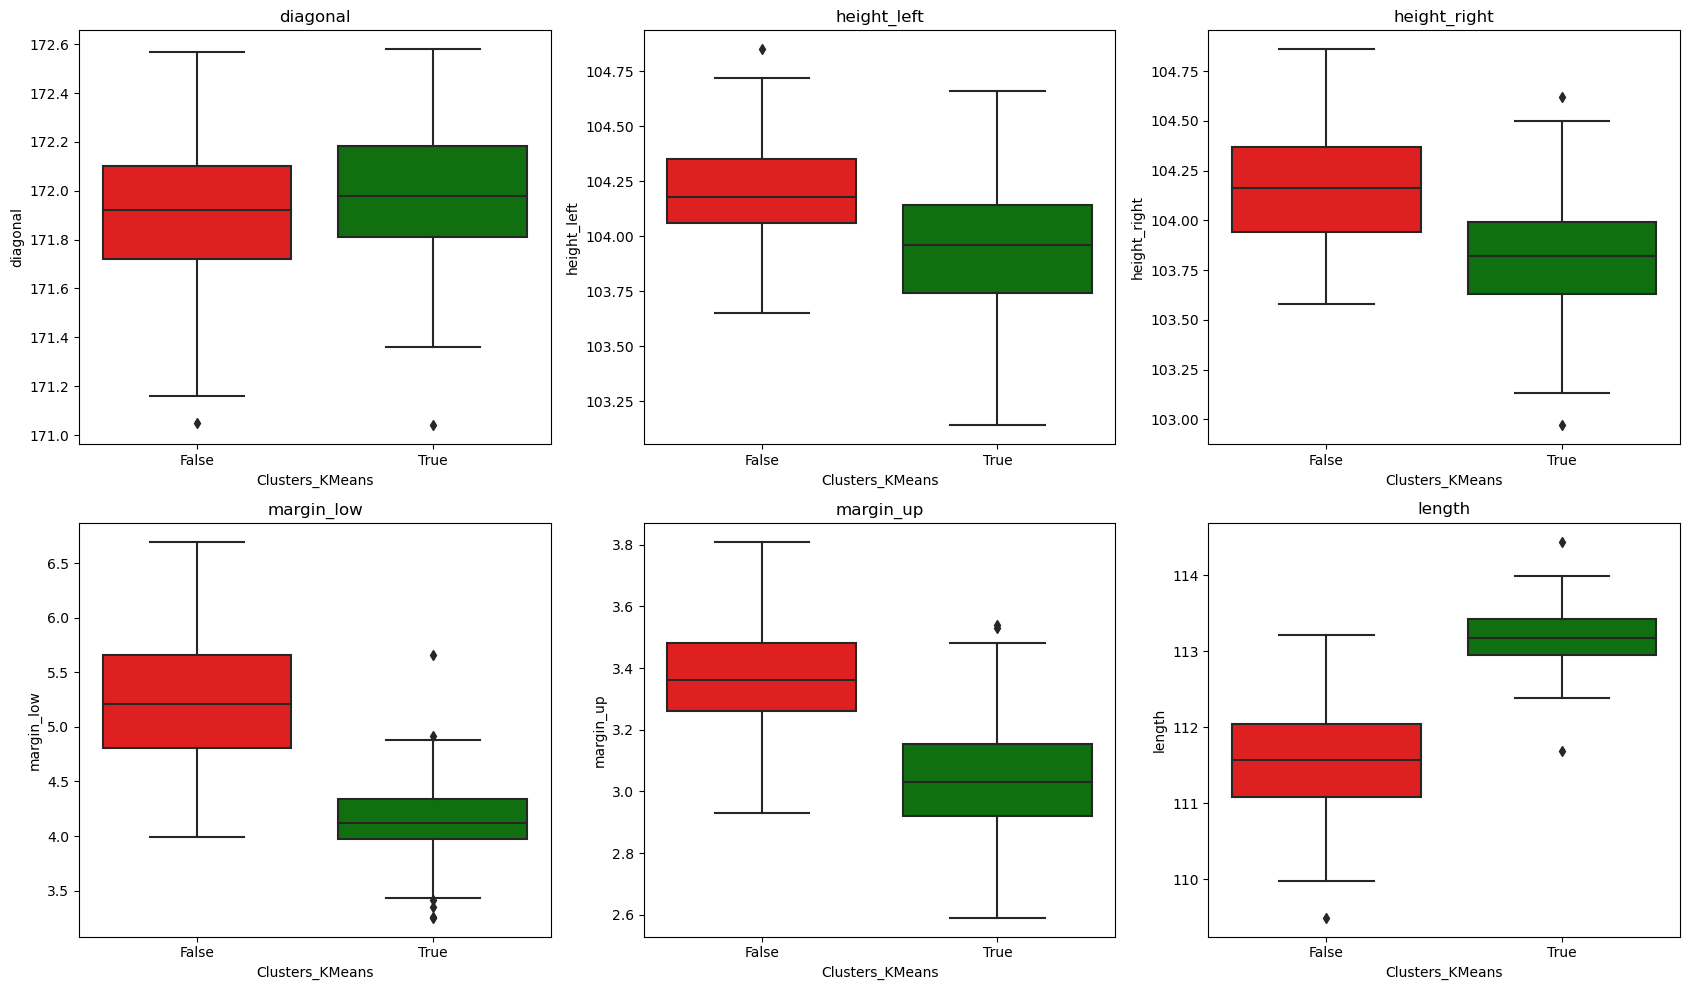

In [68]:
# Affichons la répartition des valeurs suivant les vrais et faux billets avec des boxplots
plt.figure(figsize=(17,10))

for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='Clusters_KMeans', y=feature, data=df_test_KMeans, palette=['red', 'green'])
    plt.title(feature)
    plt.tight_layout()

plt.show()

#### 4.7.2 Visualisation en radarplots <a class="anchor" id="4_7_2"></a>

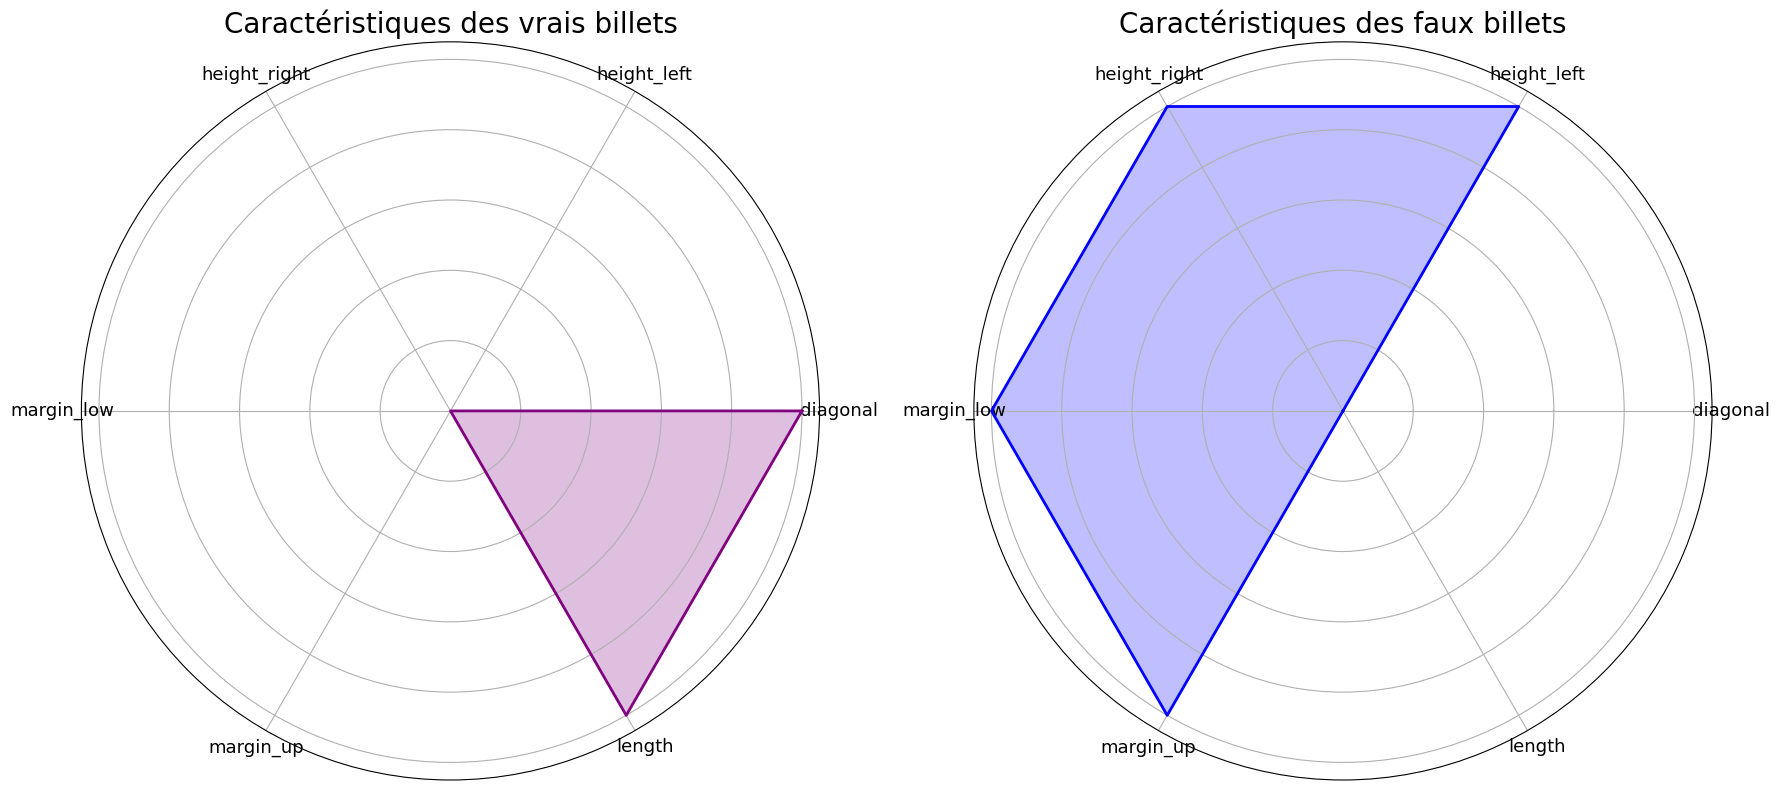

In [69]:
# Calcul des centroïdes par cluster
df_centroids = pd.DataFrame(centroids, columns=features)

# Normalisation des centroïdes pour que toutes les valeurs soient entre 0 et 1
centroids_norm = (df_centroids - df_centroids.min()) / (df_centroids.max() - df_centroids.min())

# Création du radar plot
angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

# Création des deux radars plots pour chaque cluster
fig, axes = plt.subplots(1, 2, figsize=(18, 8), subplot_kw={'polar': True})

for i, ax in enumerate(axes):
    # Sélection des valeurs des caractéristiques pour le cluster i
    values = centroids_norm.iloc[i].values
    values = np.concatenate((values, [values[0]]))
    # Couleur pour chaque cluster (bleu pour les vrais billets et violet pour les faux billets)
    color = 'blue' if i == 1 else 'purple'
    # Cluster label (True pour le premier cluster et False pour le deuxième cluster)
    cluster_label = "vrais" if clusters[i] else "faux"
    # Tracé du radar plot pour le cluster i
    ax.plot(angles, values, linewidth=2, label=f'Cluster {cluster_label}', color=color)
    ax.fill(angles, values, alpha=0.25, color=color)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, fontsize=13)
    ax.set_title(f'Caractéristiques des {cluster_label} billets', fontsize=20)
    ax.set_yticklabels([])

plt.tight_layout()
plt.show()

In [70]:
centroids_norm

,diagonal,height_left,height_right,margin_low,margin_up,length
0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,1.0,1.0,1.0,0.0


Grâce aux visualisations en boxplots et radarplots, on peut observer que les vrais billets ont tendance à être plus longs, avec une diagonale plus importante. 

En revanche, les faux billets ont tendance à être plus étroits, avec une hauteur et des marges entre les bords et l'image plus importantes.

### 4.8 Evaluation du modèle <a class="anchor" id="4_8"></a>

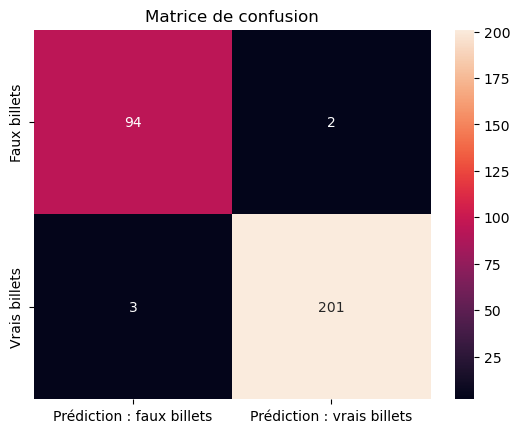

In [70]:
# Matrice de confusion
matrice_confusion = metrics.confusion_matrix(ytest, df_test_KMeans['Clusters_KMeans'])

sns.heatmap(matrice_confusion,annot=True, fmt="d",
            xticklabels=['Prédiction : faux billets', 'Prédiction : vrais billets'],
            yticklabels=['Faux billets', 'Vrais billets'])
plt.title('Matrice de confusion')
plt.show()

Sur les 300 billets du Test set, le modèle a prédit : 

    - 97 faux billets (pour réellement 96 faux billets dont 94 avec succès),
    - et, 203 vrais billets (pour réellement 204 vrais billets dont 201 avec succès).

In [71]:
# Performances globales
print(metrics.classification_report(ytest, df_test_KMeans['Clusters_KMeans']))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97        96
           1       0.99      0.99      0.99       204

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



## 5. Conclusion <a class="anchor" id="5"></a>

Le f1-score va comparer les prédictions positives aux faux négatifs et faux positifs faites par le modèle. 

Ce score nous permet donc d'évaluer les deux modèles.

In [72]:
# Affichons le f1-score de la régression logistique et le f1-score du KMeans afin de comparer les 2 modèles
metrics_RegLog = metrics.f1_score(ytest_LogReg, y_pred_LogReg)
metrics_KMeans = metrics.f1_score(ytest, df_test_KMeans['Clusters_KMeans'])

f1_scores = pd.DataFrame(data =[metrics_RegLog, metrics_KMeans], index=['Régression Logistique', 'KMeans'], columns=['f1-score'])

print(f1_scores)
print()
if metrics_RegLog > metrics_KMeans:
    print('Le modèle choisi est la régression logistique avec un score de : ', round(metrics_RegLog,4))
else:
    print('Le modèle choisi est la classification par KMeans avec un score de : ', round(metrics_KMeans,4))

                       f1-score
Régression Logistique  0.997531
KMeans                 0.987715

Le modèle choisi est la régression logistique avec un score de :  0.9975


## 6. Enregistrement des données utiles à l'application finale <a class="anchor" id="6"></a>

In [73]:
# Sauvegarder le modèle de régression logistique dans un fichier pickle
with open('modele_RegLog.pickle', 'wb') as file:
    pickle.dump(select.estimator_, file)
    
# Sauvegarder le modèle du KMeans dans un fichier pickle
with open('modele_Kmeans.pickle', 'wb') as file:
    pickle.dump(clusters_kmeans, file)
    
# Sauvegarder la 'sélection' des variables dans un fichier pickle
with open('selection.pickle', 'wb') as file:
    pickle.dump(select.support_, file)
    
# Sauvegarder le dictionnaire d'identification des clusters KMeans
with open('id_Kmeans.pickle', 'wb') as file:
    pickle.dump(clusters, file)